<a href="https://colab.research.google.com/github/TipsyPanda/ComplexBridges/blob/main/BridgeDataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt

# Paths
DATA_DIR = "/content/drive/MyDrive/ComplexSystemDesign/Data/"


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Read in the dataset
url = "https://github.com/TipsyPanda/ComplexBridges/raw/main/ipmb_5sensors_30min_1_to_10hz.csv"
bridgeData = pd.read_csv(url)

In [7]:
bridgeData.head()

,timestamp,bridge_id,span_id,sensor_id,sensor_type,value,unit,traffic_load_proxy,rule_threshold,anomaly,anomaly_type
0,2025-10-10T12:00:00,BRIDGE_A01,SPAN_1,SG_001,strain_gauge,118.571847,microstrain,0.5,200.00,0,NaN
1,2025-10-10T12:00:00,BRIDGE_A01,SPAN_2,SG_002,strain_gauge,128.986727,microstrain,0.5,200.00,0,NaN
2,2025-10-10T12:00:00,BRIDGE_A01,SPAN_1,ACC_101,accelerometer_rms,0.020849,g,0.5,0.05,0,NaN
3,2025-10-10T12:00:00,BRIDGE_A01,SPAN_2,ACC_102,accelerometer_rms,0.015481,g,0.5,0.05,0,NaN
4,2025-10-10T12:00:00,BRIDGE_A01,SPAN_2,TMP_201,temperature,21.884280,C,0.5,35.00,0,NaN


In [8]:
bridgeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           90000 non-null  object 
 1   bridge_id           90000 non-null  object 
 2   span_id             90000 non-null  object 
 3   sensor_id           90000 non-null  object 
 4   sensor_type         90000 non-null  object 
 5   value               90000 non-null  float64
 6   unit                90000 non-null  object 
 7   traffic_load_proxy  90000 non-null  float64
 8   rule_threshold      90000 non-null  float64
 9   anomaly             90000 non-null  int64  
 10  anomaly_type        3852 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 7.6+ MB


In [9]:
bridgeData.isna().sum()
#only empty values in anomaly type since it only shows if there is an anomaly

,0
timestamp,0
bridge_id,0
span_id,0
sensor_id,0
sensor_type,0
value,0
unit,0
traffic_load_proxy,0
rule_threshold,0
anomaly,0


In [10]:
# Print description of DataFrame
bridgeData.describe()

,value,traffic_load_proxy,rule_threshold,anomaly
count,90000.000000,90000.000000,90000.000000,90000.000000
mean,60.327781,0.500000,87.020000,0.042800
std,68.617340,0.353593,93.126886,0.202407
min,0.004077,0.000000,0.050000,0.000000
25%,0.021788,0.146000,0.050000,0.000000
50%,22.029184,0.500000,35.000000,0.000000
75%,123.721347,0.854000,200.000000,0.000000
max,286.421924,1.000000,200.000000,1.000000


In [11]:
bridgeData['timestamp'] = pd.to_datetime(bridgeData['timestamp'], format='ISO8601')
bridgeData.set_index('timestamp', inplace=True)


In [12]:
bridgeData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90000 entries, 2025-10-10 12:00:00 to 2025-10-10 12:29:59.900000
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bridge_id           90000 non-null  object 
 1   span_id             90000 non-null  object 
 2   sensor_id           90000 non-null  object 
 3   sensor_type         90000 non-null  object 
 4   value               90000 non-null  float64
 5   unit                90000 non-null  object 
 6   traffic_load_proxy  90000 non-null  float64
 7   rule_threshold      90000 non-null  float64
 8   anomaly             90000 non-null  int64  
 9   anomaly_type        3852 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 7.6+ MB


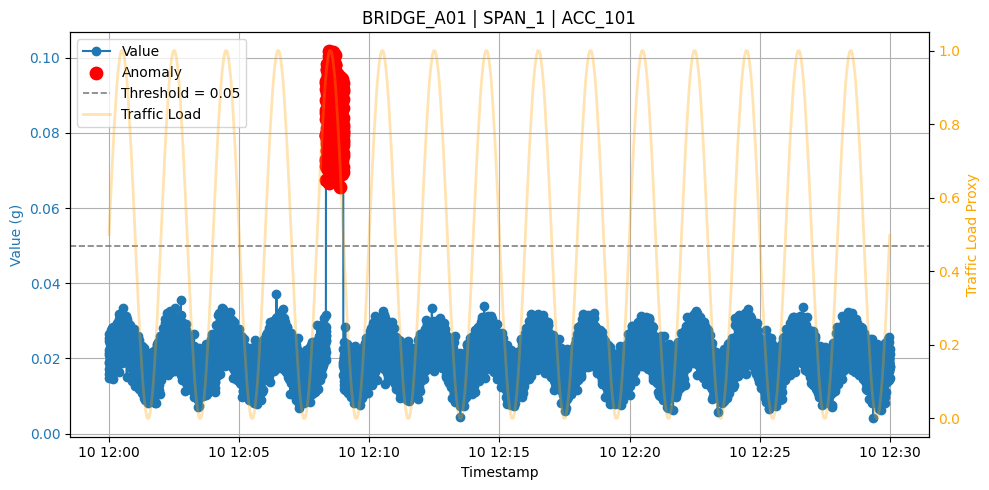

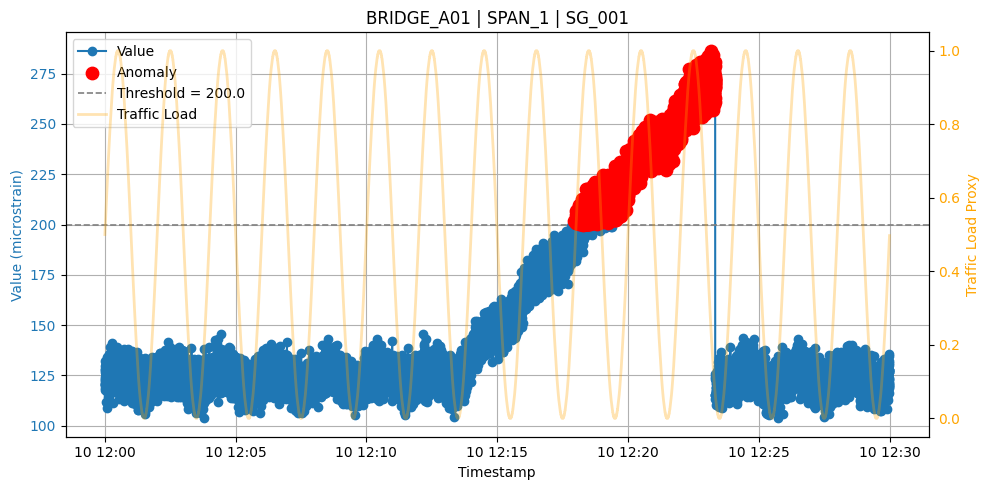

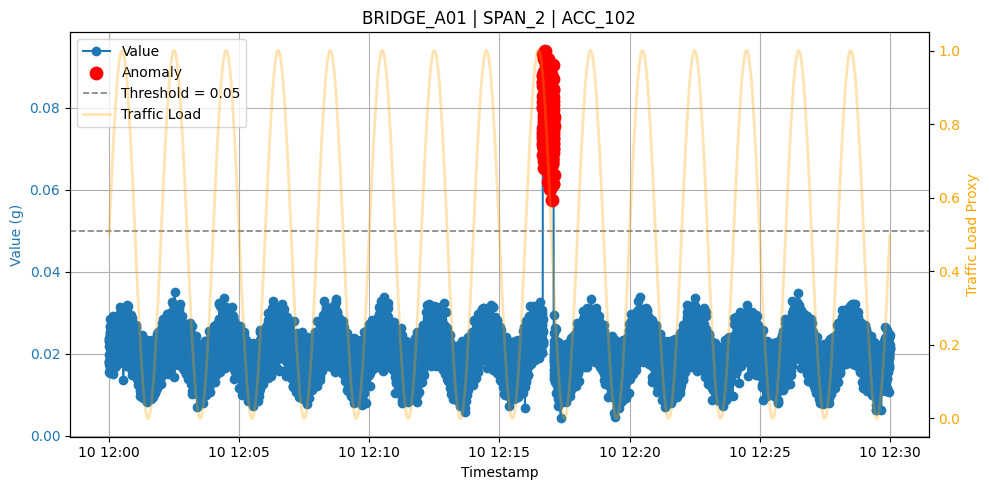

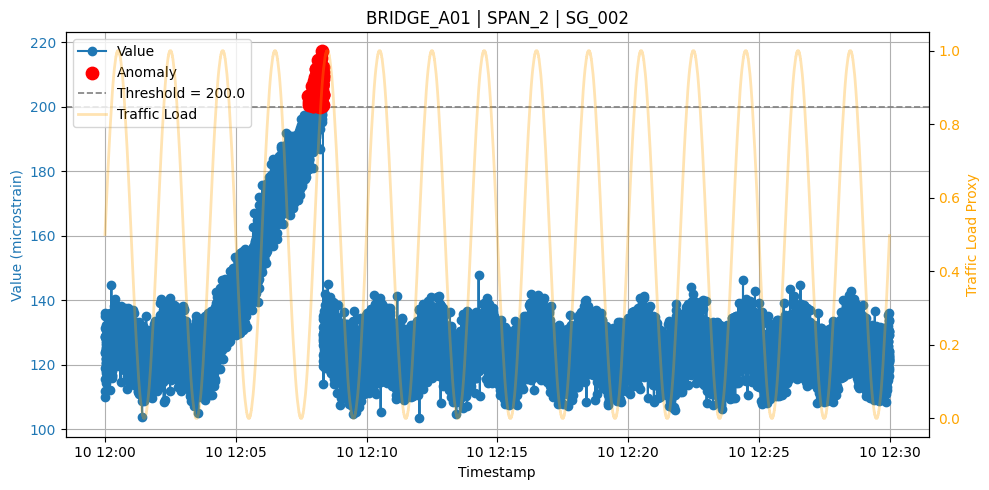

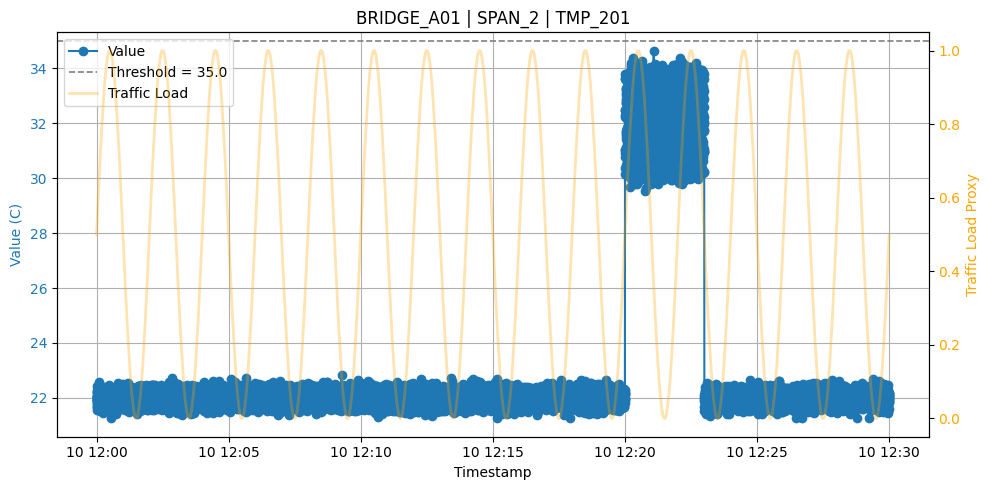

In [13]:
# Ensure anomaly is numeric (0/1)
bridgeData['anomaly'] = pd.to_numeric(bridgeData['anomaly'], errors='coerce').fillna(0).astype(int)

grouped = bridgeData.groupby(['bridge_id', 'span_id','sensor_id'])

for (bridge, span, sensor), group in grouped:
    group = group.sort_index()
    normal = group[group['anomaly'] == 0]
    anoms  = group[group['anomaly'] == 1]

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # --- Left y-axis: Sensor value ---
    ax1.plot(group.index, group['value'], marker='o', label='Value', color='tab:blue')
    if not anoms.empty:
        ax1.scatter(anoms.index, anoms['value'], s=80, c='red', label='Anomaly', zorder=3)

    # Threshold line
    if group['rule_threshold'].nunique() == 1:
        thr = group['rule_threshold'].iloc[0]
        ax1.axhline(thr, linestyle='--', linewidth=1.2, color='gray', label=f'Threshold = {thr}')
    else:
        ax1.plot(group.index, group['rule_threshold'], linestyle='--', linewidth=1.2, color='gray', label='Threshold')

    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel(f"Value ({group['unit'].iloc[0]})", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # --- Right y-axis: Traffic load proxy ---
    ax2 = ax1.twinx()
    ax2.plot(group.index, group['traffic_load_proxy'], color='orange', alpha=0.3, linewidth=2, label='Traffic Load')
    ax2.set_ylabel("Traffic Load Proxy", color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # --- Titles & Legend ---
    plt.title(f"{bridge} | {span} | {sensor}")
    ax1.grid(True)
    fig.tight_layout()

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()

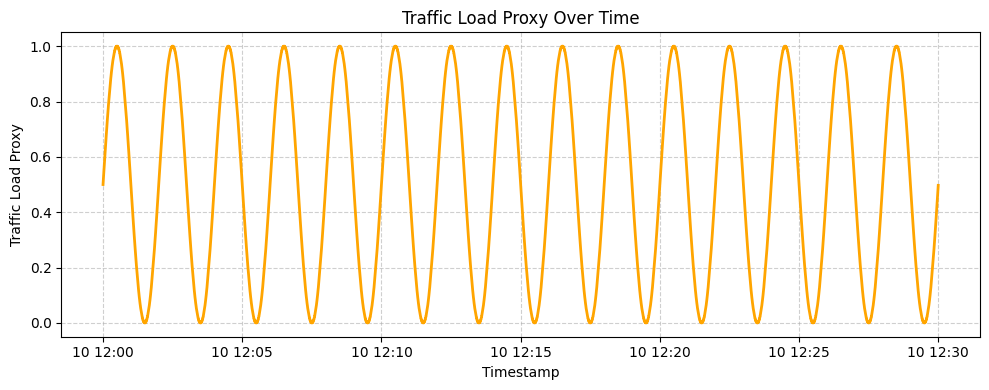

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(bridgeData.index, bridgeData['traffic_load_proxy'], color='orange', linewidth=2)

plt.title("Traffic Load Proxy Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Traffic Load Proxy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [15]:
bridgeData.head()

,bridge_id,span_id,sensor_id,sensor_type,value,unit,traffic_load_proxy,rule_threshold,anomaly,anomaly_type
timestamp,,,,,,,,,,
2025-10-10 12:00:00,BRIDGE_A01,SPAN_1,SG_001,strain_gauge,118.571847,microstrain,0.5,200.00,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_2,SG_002,strain_gauge,128.986727,microstrain,0.5,200.00,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_1,ACC_101,accelerometer_rms,0.020849,g,0.5,0.05,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_2,ACC_102,accelerometer_rms,0.015481,g,0.5,0.05,0,NaN
2025-10-10 12:00:00,BRIDGE_A01,SPAN_2,TMP_201,temperature,21.884280,C,0.5,35.00,0,NaN


In [16]:
#Save data to pickle to read in next notebook
bridgeData.to_pickle(DATA_DIR+"DF_BridgeData_cleaned.pkl")